<a href="https://colab.research.google.com/github/jiwonojo/Data-Capstone-Design/blob/main/%EB%8D%B0%EC%BA%A1%EB%94%94_11_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textblob lightgbm nltk -q

import nltk
nltk.download('punkt')   # TextBlob 문장 토큰화 용

import pandas as pd
import numpy as np
import re

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from lightgbm import LGBMClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# 경로는 상황에 맞게 수정하세요!
df = pd.read_csv("/content/fake_reviews_dataset.csv")

print(df.head())
print(df.columns)


           category  rating  \
0  Home_and_Kitchen     5.0   
1  Home_and_Kitchen     5.0   
2  Home_and_Kitchen     5.0   
3  Home_and_Kitchen     1.0   
4  Home_and_Kitchen     5.0   

                                                text  label  
0  Love this!  Well made, sturdy, and very comfor...      1  
1  love it, a great upgrade from the original.  I...      1  
2  This pillow saved my back. I love the look and...      1  
3  Missing information on how to use it, but it i...      1  
4  Very nice set. Good quality. We have had the s...      1  
Index(['category', 'rating', 'text', 'label'], dtype='object')


In [ ]:
# ---------- 기존 Feature 4개 ----------

# 1) 감성 점수 (polarity)
def get_polarity(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0.0

df['polarity'] = df['text'].apply(get_polarity)


# 2) 1인칭 대명사 개수 (personal_count)
pronoun_pattern = re.compile(r"\b(i|me|my|mine|we|us|our|ours)\b", re.I)

def count_pronouns(text):
    text = str(text)
    return len(re.findall(pronoun_pattern, text))

df['personal_count'] = df['text'].apply(count_pronouns)


# 3) polarity_diff (문장별 polarity와 문서 전체 polarity 차이 평균)
def calc_polarity_diff(text):
    text = str(text)
    try:
        blob = TextBlob(text)
        doc_p = blob.sentiment.polarity
        sentences = blob.sentences
        if len(sentences) == 0:
            return 0.0
        diffs = [abs(s.sentiment.polarity - doc_p) for s in sentences]
        return float(np.mean(diffs))
    except:
        return 0.0

df['polarity_diff'] = df['text'].apply(calc_polarity_diff)


# 4) 감탄문 비율 (exclamation_rate) = '!' 개수 / 전체 길이
def exclamation_rate(text):
    text = str(text)
    return text.count('!') / max(len(text), 1)

df['exclamation_rate'] = df['text'].apply(exclamation_rate)


# ---------- 추가 Feature 6개 ----------

# 5) 단어 수 (word_count)
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))

# 6) 문장 수 (sentence_count)
def count_sentences(text):
    text = str(text)
    try:
        return len(TextBlob(text).sentences)
    except:
        return 0

df["sentence_count"] = df["text"].apply(count_sentences)

# 7) 평점-감성 불일치도 (rating_sentiment_diff)
# rating(1~5)을 0~1 스케일로 바꾼 뒤 polarity와 차이
df["rating_sentiment_diff"] = (df["rating"] / 5.0 - df["polarity"]).abs()

# 8) 특수문자 비율 (special_char_rate) - # ? * $ % @ 등
special_pattern = re.compile(r"[#?*\$%@]")

def special_char_rate(text):
    text = str(text)
    return len(re.findall(special_pattern, text)) / max(len(text), 1)

df["special_char_rate"] = df["text"].apply(special_char_rate)

# 9) 대문자 비율 (caps_rate)
def caps_rate(text):
    text = str(text)
    if len(text) == 0:
        return 0.0
    caps = sum(1 for c in text if c.isupper())
    return caps / len(text)

df["caps_rate"] = df["text"].apply(caps_rate)

# 10) fakeword_score - 가짜 리뷰에 자주 등장하는 표현 count
fake_words = [
    "amazing", "awesome", "best", "must buy", "highly recommend", "super", "perfect",
    "life changing", "very good", "will buy again", "worth every penny",
    "great product", "love this", "highly recommended", "five stars"
]

def fakeword_score(text):
    t = str(text).lower()
    return sum(1 for fw in fake_words if fw in t)

df["fakeword_score"] = df["text"].apply(fakeword_score)


df[[
    'polarity','personal_count','polarity_diff','exclamation_rate',
    'word_count','sentence_count','rating_sentiment_diff',
    'special_char_rate','caps_rate','fakeword_score'
]].head()


,polarity,personal_count,polarity_diff,exclamation_rate,word_count,sentence_count,rating_sentiment_diff,special_char_rate,caps_rate,fakeword_score
0,0.473750,1,0.0,0.026667,12,0,0.526250,0.0,0.053333,1
1,0.558333,2,0.0,0.000000,16,0,0.441667,0.0,0.012500,0
2,0.250000,2,0.0,0.000000,14,0,0.750000,0.0,0.029851,0
3,0.400000,1,0.0,0.012346,17,0,0.200000,0.0,0.024691,1
4,0.740000,1,0.0,0.000000,18,0,0.260000,0.0,0.035294,0


In [ ]:
feature_cols = [
    'polarity', 'personal_count', 'polarity_diff', 'exclamation_rate',
    'word_count', 'sentence_count', 'rating_sentiment_diff',
    'special_char_rate', 'caps_rate', 'fakeword_score'
]

target_col = 'label'
category_col = 'category'

X = df[feature_cols + [category_col]]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (28368, 11)
Test shape: (12158, 11)


In [ ]:
# category one-hot 인코딩
X_train_enc = pd.get_dummies(X_train, columns=[category_col])
X_test_enc  = pd.get_dummies(X_test,  columns=[category_col])

# 컬럼 맞춰주기
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1)
X_test_enc = X_test_enc.fillna(0)

# LightGBM 모델 정의
lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 학습
lgbm.fit(X_train_enc, y_train)

# 예측
test_proba = lgbm.predict_proba(X_test_enc)[:, 1]
test_pred_05 = (test_proba >= 0.5).astype(int)

# Global F1 / AUC
global_f1 = f1_score(y_test, test_pred_05)
global_auc = roc_auc_score(y_test, test_proba)

print("=== Global Metrics (th=0.5) ===")
print("F1-score:", global_f1)
print("ROC-AUC:", global_auc)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14206, number of negative: 14162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1595
[LightGBM] [Info] Number of data points in the train set: 28368, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500776 -> initscore=0.003102
[LightGBM] [Info] Start training from score 0.003102
=== Global Metrics (th=0.5) ===
F1-score: 0.7286648588291593
ROC-AUC: 0.8011970641464994


In [ ]:
def eval_by_category(df_split, y_true, proba, category_col='category', thresholds=None):
    """
    df_split: category 컬럼 포함된 X_test 원본 DataFrame
    y_true  : 실제 라벨 (array-like)
    proba   : 예측 확률 (1 클래스 확률)
    thresholds: dict {카테고리: threshold}, None이면 0.5 사용
    """
    result = []
    cats = df_split[category_col].unique()

    for c in cats:
        idx = (df_split[category_col] == c)
        y_c = y_true[idx]
        p_c = proba[idx]
        if len(y_c) == 0:
            continue

        th = 0.5 if thresholds is None or c not in thresholds else thresholds[c]
        y_pred_c = (p_c >= th).astype(int)

        f1_c = f1_score(y_c, y_pred_c)
        try:
            auc_c = roc_auc_score(y_c, p_c)
        except ValueError:
            auc_c = np.nan

        result.append({
            'category': c,
            'threshold': th,
            'F1': f1_c,
            'AUC': auc_c,
            'n_samples': len(y_c)
        })
    return pd.DataFrame(result)


In [ ]:
# X_test에 category가 있으니 그대로 사용
df_test = X_test.copy()
df_test[target_col] = y_test.values

cat_result_default = eval_by_category(
    df_split=df_test,
    y_true=y_test.values,
    proba=test_proba,
    category_col=category_col,
    thresholds=None  # 모두 0.5
)

cat_result_default.head()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,category,threshold,F1,AUC,n_samples
0,Toys_and_Games,0.5,0.733930,0.790068,1158
1,Pet_Supplies,0.5,0.752000,0.812027,1297
2,Movies_and_TV,0.5,0.725157,0.805840,1071
3,Books,0.5,0.720487,0.800272,1299
4,Electronics,0.5,0.677338,0.757421,1170


In [ ]:
def find_best_thresholds_by_category(df_split, y_true, proba, category_col='category'):
    thresholds_dict = {}
    cats = df_split[category_col].unique()
    candidate_thresholds = np.linspace(0.1, 0.9, 17)  # 0.1 ~ 0.9, 0.05 간격

    for c in cats:
        idx = (df_split[category_col] == c)
        y_c = y_true[idx]
        p_c = proba[idx]

        if len(y_c) == 0:
            continue

        best_f1 = -1
        best_th = 0.5

        for th in candidate_thresholds:
            y_pred_c = (p_c >= th).astype(int)
            if len(np.unique(y_pred_c)) == 1:
                continue  # 전부 0/1이면 패스

            f1_c = f1_score(y_c, y_pred_c)
            if f1_c > best_f1:
                best_f1 = f1_c
                best_th = th

        thresholds_dict[c] = best_th

    return thresholds_dict


In [ ]:
best_ths = find_best_thresholds_by_category(
    df_split=df_test,
    y_true=y_test.values,
    proba=test_proba,
    category_col=category_col
)

print("Best thresholds by category:")
best_ths


Best thresholds by category:


{'Toys_and_Games': np.float64(0.35),
 'Pet_Supplies': np.float64(0.45000000000000007),
 'Movies_and_TV': np.float64(0.4),
 'Books': np.float64(0.35),
 'Electronics': np.float64(0.35),
 'Sports_and_Outdoors': np.float64(0.45000000000000007),
 'Home_and_Kitchen': np.float64(0.4),
 'Tools_and_Home_Improvement': np.float64(0.45000000000000007),
 'Clothing_Shoes_and_Jewelry': np.float64(0.45000000000000007),
 'Kindle_Store': np.float64(0.4),
 'Automotive': np.float64(0.1),
 'Home Appliances': np.float64(0.1),
 'Gardening': 0.5,
 'Food': np.float64(0.30000000000000004),
 'Sporting Goods': np.float64(0.45000000000000007),
 'Clothing': np.float64(0.1),
 'Beauty': np.float64(0.35),
 'Toys': 0.5}

In [ ]:
cat_result_adaptive = eval_by_category(
    df_split=df_test,
    y_true=y_test.values,
    proba=test_proba,
    category_col=category_col,
    thresholds=best_ths
)

cat_result_adaptive.head()


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,category,threshold,F1,AUC,n_samples
0,Toys_and_Games,0.35,0.756149,0.790068,1158
1,Pet_Supplies,0.45,0.752044,0.812027,1297
2,Movies_and_TV,0.40,0.744409,0.805840,1071
3,Books,0.35,0.752000,0.800272,1299
4,Electronics,0.35,0.708215,0.757421,1170


In [ ]:
def apply_category_thresholds(df_split, proba, thresholds, category_col='category'):
    th_array = np.array([thresholds.get(cat, 0.5) for cat in df_split[category_col]])
    return (proba >= th_array).astype(int)

test_pred_adaptive = apply_category_thresholds(df_test, test_proba, best_ths, category_col)

f1_adaptive = f1_score(y_test, test_pred_adaptive)
print("=== Global F1 with Adaptive Thresholds ===")
print("F1-score:", f1_adaptive)


=== Global F1 with Adaptive Thresholds ===
F1-score: 0.7475349365113144


트리 분기 시각화

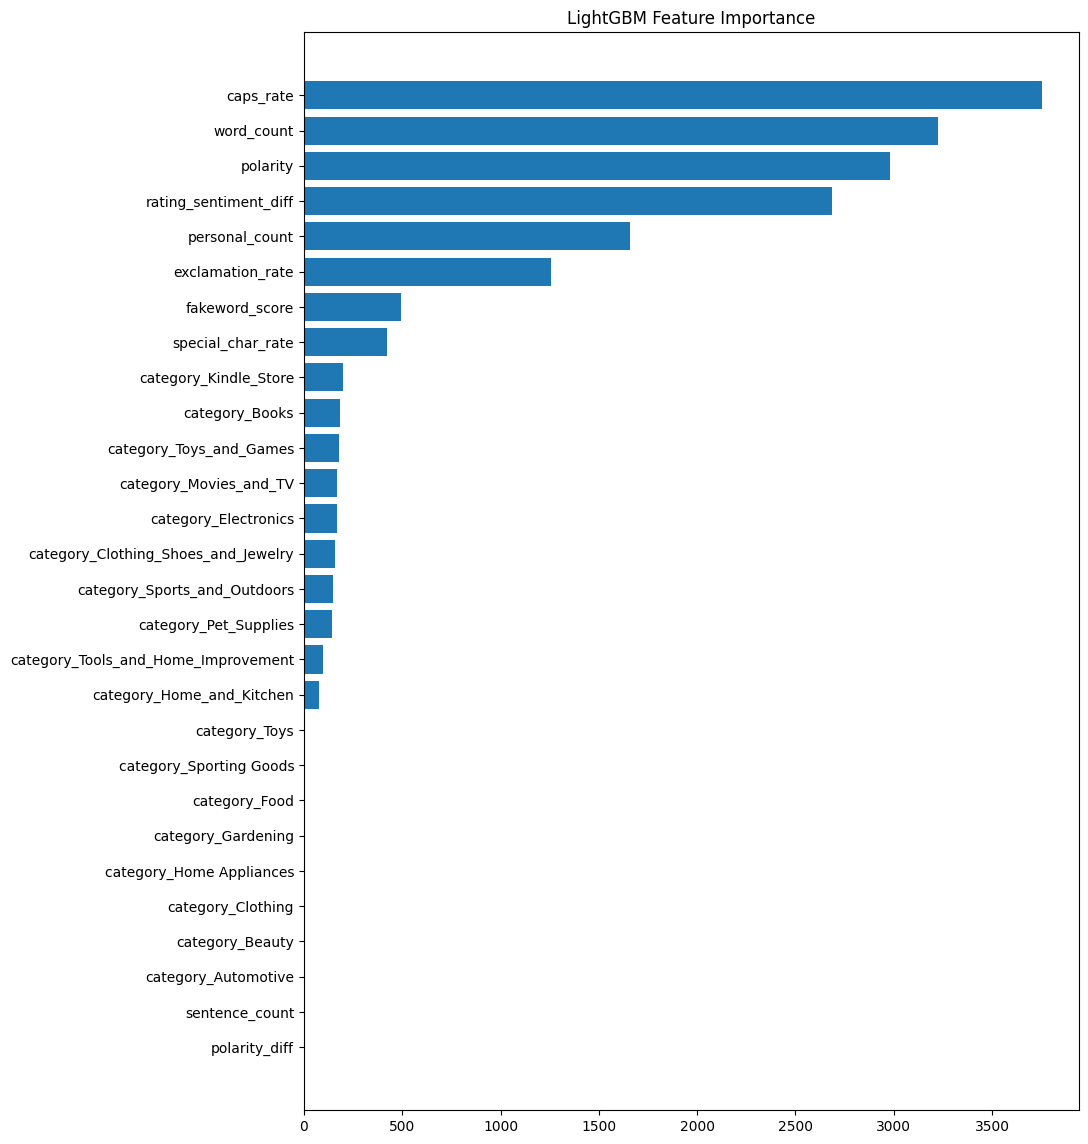

In [ ]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

# feature importance
importance = lgbm.feature_importances_
names = X_train_enc.columns

indices = np.argsort(importance)

plt.figure(figsize=(10, 14))
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), names[indices])
plt.title("LightGBM Feature Importance")
plt.show()


In [ ]:
!apt-get install graphviz -y
!pip install graphviz -q


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


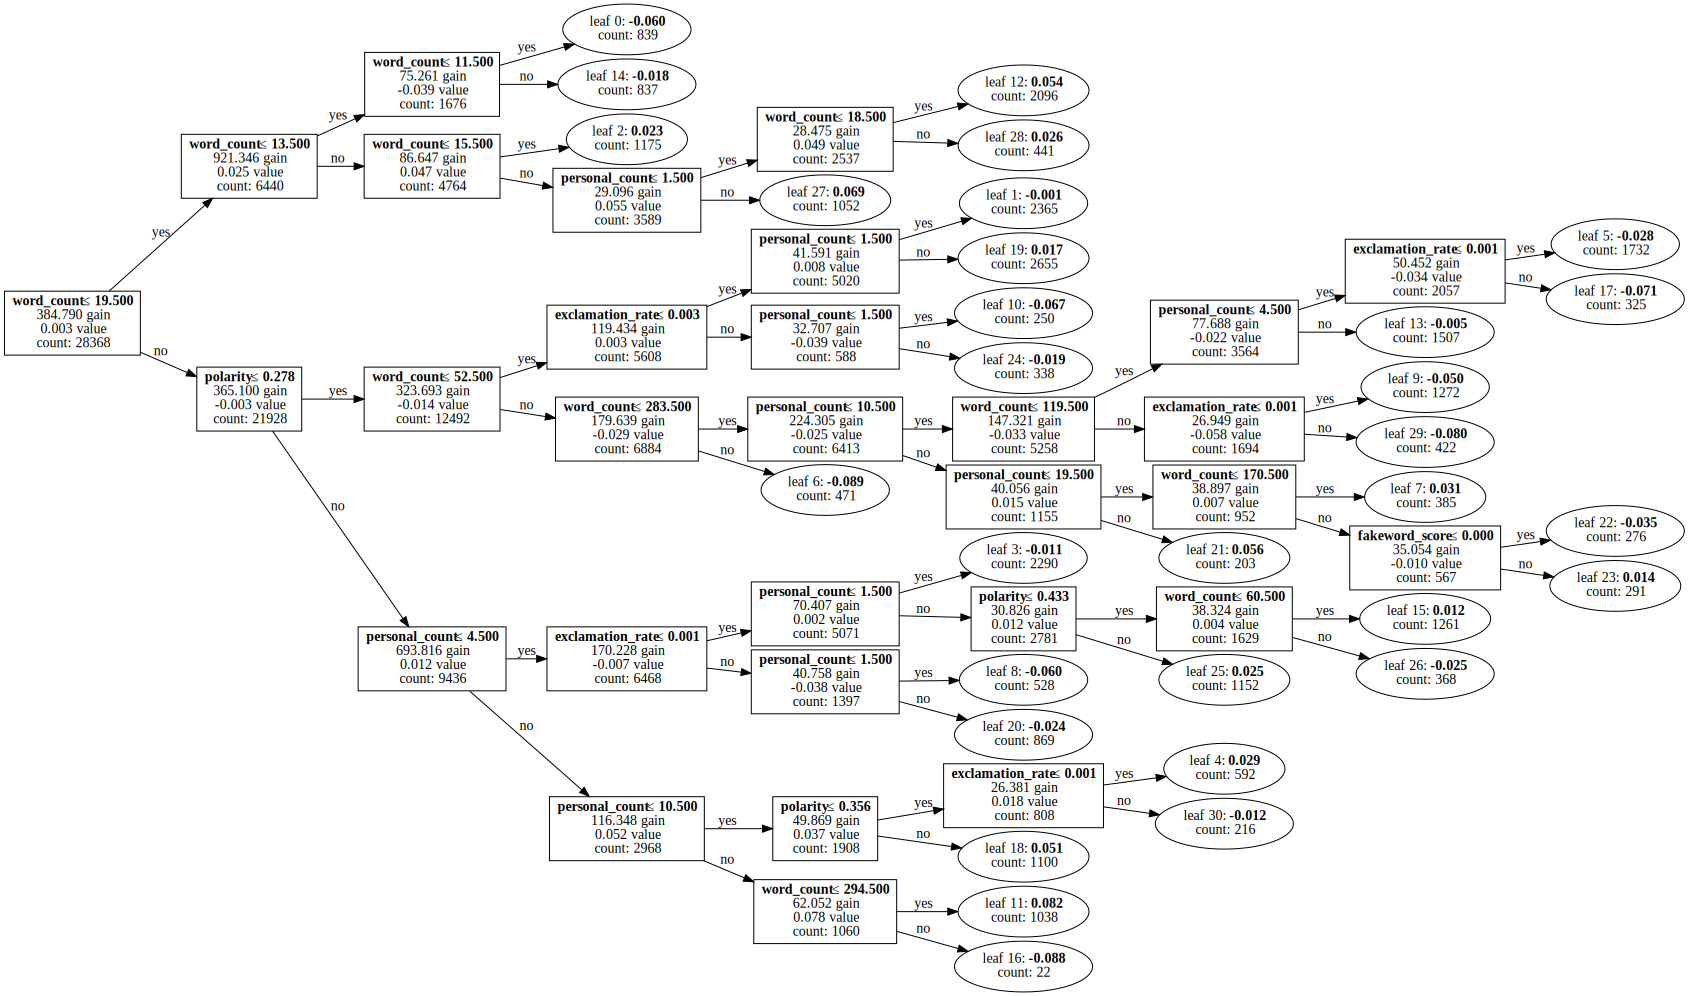

In [ ]:
import graphviz
import lightgbm as lgb

# lightgbm booster 가져오기
booster = lgbm.booster_

# 예: 첫 번째 트리(0번 트리)
graph = lgb.create_tree_digraph(
    booster,
    tree_index=0,
    name='Tree0',
    show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count']
)

graph


In [ ]:
df

,category,rating,text,label,polarity,personal_count,polarity_diff,exclamation_rate,word_count,sentence_count,rating_sentiment_diff,special_char_rate,caps_rate,fakeword_score
0,Home_and_Kitchen,5.0,"Love this! Well made, sturdy, and very comfor...",1,0.473750,1,0.0,0.026667,12,0,0.526250,0.0,0.053333,1
1,Home_and_Kitchen,5.0,"love it, a great upgrade from the original. I...",1,0.558333,2,0.0,0.000000,16,0,0.441667,0.0,0.012500,0
2,Home_and_Kitchen,5.0,This pillow saved my back. I love the look and...,1,0.250000,2,0.0,0.000000,14,0,0.750000,0.0,0.029851,0
3,Home_and_Kitchen,1.0,"Missing information on how to use it, but it i...",1,0.400000,1,0.0,0.012346,17,0,0.200000,0.0,0.024691,1
4,Home_and_Kitchen,5.0,Very nice set. Good quality. We have had the s...,1,0.740000,1,0.0,0.000000,18,0,0.260000,0.0,0.035294,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40521,Beauty,4.0,The shampoo has a pleasant scent and cleans we...,1,0.366667,0,0.0,0.000000,17,0,0.433333,0.0,0.020408,0
40522,Clothing,3.0,The jacket is stylish but not very warm. As pe...,1,0.288141,0,0.0,0.000000,18,0,0.311859,0.0,0.038835,0
40523,Sporting Goods,5.0,The running shoes provide excellent support. A...,1,0.580000,0,0.0,0.000000,14,0,0.420000,0.0,0.020000,1
40524,Food,4.0,The pasta cooks perfectly every time. Accordin...,1,0.711111,0,0.0,0.000000,19,0,0.088889,0.0,0.039216,1
